# Libraries

In [95]:
from __future__ import division
import numpy as np
import scipy.io as scipy
import matplotlib.pyplot as plt
!pip install mne
import mne
from mne.preprocessing import ICA
from numpy import *
from numpy.fft import *
import mne
# from mne.channels import read_layout
import scipy.signal as signal
from matplotlib.pyplot import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import sklearn
from mne.decoding import CSP

# Functions

In [3]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

# Loading Data

In [4]:
p2_all = loadmat('P2_AllLifts.mat')
print( "All Lifts loaded")



#these are the series we are looking at for subject 2. Everything except series 1 and 6
trials_included=[2, 3, 4, 5, 7, 8, 9] 

#corresponding row indices in P.AllLifts where each series starts. Index is off by one bc of how python indexes things
trialStartIdx = [28, 62, 96, 130, 192, 226, 260]

#data structure to hold all EEG trials 

eeg_trials = []
emg_trials= []
y_label_eeg = []
y_label_emg = []
CLOSE_VAL = 0
OPEN_VAL = 1

series_counter = 0
trial_counter = 1
i = 0
for s in trials_included:
    # load all the series specified in trials_included
    series_filename = 'WS_P2_S{series}.mat'.format(series = s)
    p_series = loadmat(series_filename)
    print("Series data loaded")
    series_counter = series_counter + 1
    print("series_counter: ", series_counter)

    #identifying the starting row index in p.ALLLifts for the first trial of the current series
    tStart = trialStartIdx[i]
    i += 1
    trial_counter = 1
    #range for the for loop is 34 values bc there are 34 trials in each series
    for trial_num in range(tStart, tStart + 34):
        
        #retrieving the point in time when both fingers touched object
        #index values are one cloumn and one row before target value
        tBothDigitTouch = np.array(p2_all['P']['AllLifts'])[trial_num, 14]
        
        tBothReleased = np.array(p2_all['P']['AllLifts'])[trial_num, 22]
        
        #converting time points to row indices to be accessed in windowed struct
        #500 samples every second, so timepoint should be divided by 0.002
        idxCloseEnd = int(tBothDigitTouch // 0.002) + int(0.8//0.002)
        idxCloseStart = int(tBothDigitTouch // 0.002)- int(0.8//0.002)
        
        idxOpenEnd = int(tBothReleased // 0.002)+ int(0.8//0.002)
        idxOpenStart = int(tBothReleased // 0.002)- int(0.8//0.002)
        
        idxCloseEndEMG = int(tBothDigitTouch // 0.0002) + int(0.8//0.0002)
        idxCloseStartEMG = int(tBothDigitTouch // 0.0002) - int(0.8//0.0002)
        
        idxOpenEndEMG = int(tBothReleased // 0.0002) + int(0.8//0.0002)
        idxOpenStartEMG = int(tBothReleased // 0.0002) - int(0.8//0.0002)

        eeg_trial_close = np.array(p_series['ws']['win'][0]['eeg'])[idxCloseStart:idxCloseEnd].T
        eeg_trial_open = np.array(p_series['ws']['win'][0]['eeg'])[idxOpenStart:idxOpenEnd].T 
        emg_trial_close = np.array(p_series['ws']['win'][0]['emg'])[idxCloseStartEMG:idxCloseEndEMG].T 
        emg_trial_open = np.array(p_series['ws']['win'][0]['emg'])[idxOpenStartEMG:idxOpenEndEMG].T
        
        if(eeg_trial_close.shape[1]== 800):
            eeg_trials.append(eeg_trial_close)
            y_label_eeg.append(CLOSE_VAL)
        
        if(eeg_trial_open.shape[1]== 800):
            eeg_trials.append(eeg_trial_open)
            y_label_eeg.append(OPEN_VAL)
        
        #print("emg close: " , emg_trial_close.shape)
        if(emg_trial_close.shape[1]== 8000):
            #print("appending close")
            emg_trials.append(emg_trial_close)
            y_label_emg.append(CLOSE_VAL)
            
        #print("emg open: " , emg_trial_open.shape)
        if(emg_trial_open.shape[1]== 8000):
            emg_trials.append(emg_trial_open)
            y_label_emg.append(OPEN_VAL)
            #print("appending open")
        
        
        ##if((eeg_trial_close.shape[1]== 800) & (eeg_trial_open.shape[1]== 800) & (emg_trial_open.shape[1]== 8000) & (emg_trial_close.shape[1]== 8000)):
        
#             eeg_trials.append(eeg_trial_open)
#             eeg_trials.append(eeg_trial_close)
#             emg_trials.append(emg_trial_open)
#             emg_trials.append(emg_trial_close)
#             print("appended all")
            
        
        trial_counter = trial_counter +1
eeg_trials = np.asarray(eeg_trials)
emg_trials = np.asarray(emg_trials)
                
                                                            

All Lifts loaded
Series data loaded
series_counter:  1
Series data loaded
series_counter:  2
Series data loaded
series_counter:  3
Series data loaded
series_counter:  4
Series data loaded
series_counter:  5
Series data loaded
series_counter:  6
Series data loaded
series_counter:  7


In [174]:

print("Dimensions of EEG Trials train:" , eeg_trials.shape)
print("459 trials x 32 electrodes x 800 time points")
#print(emg_trials.shape)
print("Dimensions of EEG Trials test:" , len(y_label_eeg))
#print(len(y_label_eeg))
#print(len(y_label_emg))

Dimensions of EEG Trials train: (459, 32, 800)
459 trials x 32 electrodes x 800 time points
Dimensions of EEG Trials test: 459


In [107]:
ch_pos = {"Fp1": [-2.7, 8.6, 3.6],"Fp2": [2.7, 8.6, 3.6],
"F7": [-6.7, 5.2, 3.6],"F3": [-4.7, 6.2, 8],
"F2": [0, 6.7, 9.5],"F4": [4.7, 6.2, 8],
"F8": [6.7, 5.2, 3.6],
"FC5": [-5.5, 3.2, 6.6],
"FC1": [-3, 3.3, 11],"FC2": [3, 3.3, 11],
"FC6": [5.5, 3.2, 6.6],"T7": [-7.8, 0, 3.6],
"C3": [-6.1, 0, 9.7],"Cz": [0, 0, 12],
"C4": [6.1, 0, 9.7],"T8": [7.8, 0, 3.6],
"TP9": [-7.3, -2.5, 0],"CP5": [-7.2, -2.7, 6.6],
"CP1": [-3, -3.2, 11],"CP2": [3, -3.2, 11],
"CP6": [7.2, -2.7, 6.6], "TP10": [7.3, -2.5, 0],
"P7": [-6.7, -5.2, 3.6],"P3": [-4.7, -6.2, 8],
"Pz": [0, -6.7, 9.5],"P4": [4.7, -6.2, 8],
"P8": [6.7, -5.2, 3.6],"PO9": [-4.7, -6.7, 0],
"O1": [-2.7, -8.6, 3.6],"Oz": [0, -9, 3.6],
"O2": [2.7, -8.6, 3.6],"PO10": [4.7, -6.7, 0]}
montage = mne.channels.make_dig_montage(ch_pos)
info = mne.create_info(ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'F2', 'F4', 'F8', 'FC5', 'FC1', 
                                   'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 
                                   'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 
                                   'PO9', 'O1', 'Oz', 'O2', 'PO10'], sfreq=500, ch_types='eeg')
info = info.set_montage(montage = montage , verbose = None)
ica = ICA( n_components = 32)

<ipython-input-107-0ba95c16af1e>:23: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = info.set_montage(montage = montage , verbose = None)


In [120]:
def preprocess_trial_data( data, info):
    # Create raw array object
    mne_rarray = mne.io.RawArray( data, info, copy = "both")
    mne_rarray.set_montage(montage)
    ica.fit(mne_rarray)
    ica.exclude =  [5, 12]
    reconst_raw = raw.copy() 
    ica.apply(reconst_raw)
    # Common-average referencing of data
    rrf_rarray = reconst_raw.copy().set_eeg_reference( ref_channels='average')

    
    # Application of FIR bandpass filter
    #fil_length = str(((441-1)/(2*500))*1000) + "ms"
    flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
    
    
   
    #################################################################################
    # TODO: Determine if we want to return an ica object instead of the filtered data
    #     ica = mne.preprocessing.ICA( n_components = 32)
    #     ica.fit( flt_rarray)
    #     return ica
    #################################################################################
    
    return flt_rarray

In [121]:
trials = np.arange( 0, len( eeg_trials))

flt_rarray_data = []
flt_data = []

for trial in trials:
    trial_data = eeg_trials[ trial]
    flt_rarray_data.append(preprocess_trial_data( trial_data, info))
    flt_data.append( preprocess_trial_data( trial_data, info).get_data())
    
flt_data = np.asarray( flt_data)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 1.0s.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.8s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 1.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 1.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Selecting by number: 32 components
Fitting ICA took 0.7s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a wh

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Selecting by number: 32 components
Fitting ICA took 1.9s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a wh

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 1.0s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.8s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Re

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 1.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Selecting by number: 32 components
Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a wh

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.8s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.7s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Selecting by number: 32 components
Fitting ICA took 0.7s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a wh

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Selecting by number: 32 components
Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a wh

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG refere

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG refere

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.1s.
Transforming to ICA space (32 compone

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG refere

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.8s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.7s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.8s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.7s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Selecting by number: 32 components
Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a wh

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) me

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 1.0s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 1.0s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 1.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 s

<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)



Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.8s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Selecting by number: 32 components
Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a wh

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Re

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.7s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Re

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Re

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.6s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.7s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.8s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Re

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.1s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)



Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.2s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.4s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 compon

/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)
<ipython-input-120-1b9efac0d837>:4: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_rarray.set_montage(montage)


Fitting ICA took 0.3s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-120-1b9efac0d837>:15: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = rrf_rarray.copy().filter( l_freq = 7.5, h_freq = 30)


In [133]:
print(flt_data.shape)

(459, 32, 800)


In [ ]:
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)
csp.fit(eeg_trials, y_label_eeg)

Effective window size : 1.600 (s)


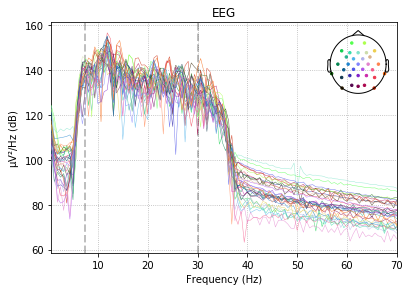

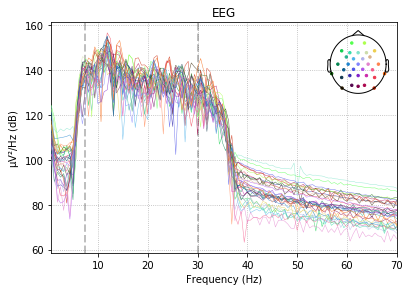

In [130]:
flt_rarray_data[0].plot_psd( fmin = 0.1, fmax = 70)


In [131]:
psd, freqs = mne.time_frequency.psd_array_welch(flt_data, sfreq= 500,fmin = 7.5, fmax = 30)

Effective window size : 0.512 (s)


In [156]:
all_trials_avg = []
for i in range(len(psd)):
    trial_psd = psd[i,:,:]
    mu_avg = np.mean(trial_psd[:,(freqs <= 12) & (freqs >7.5)], axis = 1)
    beta_avg = np.mean(trial_psd[:,(freqs <= 30) & (freqs >12)], axis = 1)
    
    trial_avg = np.hstack((mu_avg, beta_avg))
    all_trials_avg.append(trial_avg)
    
all_trials_avg = np.asarray(all_trials_avg)

In [161]:
x_train,x_test, y_train, y_test = sklearn.model_selection.train_test_split(all_trials_avg, y_label_eeg, test_size=0.3, random_state=42)

In [162]:
x_train.shape

(321, 64)

In [169]:

log_reg_psd = LogisticRegression(penalty = 'none', max_iter = 10000) #Then fit it to data
log_reg_psd.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [171]:
score_psd = log_reg_psd.score(x_test, y_test)
print(score_psd)

0.7753623188405797
